/var/folders/wn/j_ytm31108z7jt5f1x0d7j1c0000gq/T/ipykernel_57469/4118772512.py:32: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  main = plt.subplot(H, W, (I(0, 1), I(W - 2, H - 1)))


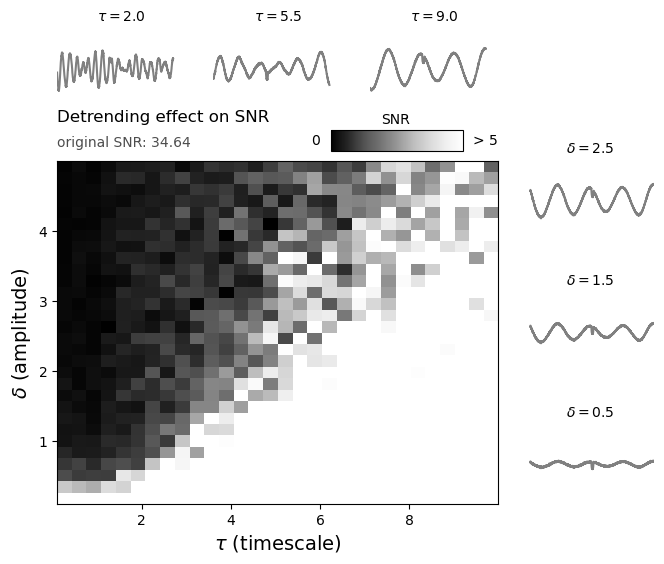

In [5]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
import sys

sys.path.append("../scripts")
from make_lightcurve import make_lc
from make_params import make
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from utils import depth as true_depth
from utils import error

df = pd.read_csv("../data/results.csv")

n = 3  # number of small plots
scale = 1.2
W = n + 1
H = n + 1

fig = plt.figure(None, (7, 6))


def I(i, j):
    return int(j * W + i) + 1


for i in range(H * W):
    ax = plt.subplot(H, W, i + 1)

## Main plot
main = plt.subplot(H, W, (I(0, 1), I(W - 2, H - 1)))

bins = (30, 30)

if df is not None:
    snr, var, amp = df.values.T.astype(float)
    stats = binned_statistic_2d(var, amp, snr, bins=bins)
    im = main.imshow(
        stats.statistic.T,
        origin="lower",
        extent=(
            stats.x_edge.min(),
            stats.x_edge.max(),
            stats.y_edge.min(),
            stats.y_edge.max(),
        ),
        aspect="auto",
        vmax=5,
        cmap="Greys_r",
    )

main.set_ylabel(
    r"$\delta$ (amplitude)",
    fontsize=14,
)
main.set_xlabel(
    r"$\tau$ (timescale)",
    fontsize=14,
)
params = true_depth
original_snr = true_depth / np.sqrt(np.mean(error) ** 2 / n)

main.set_title(f"Detrending effect on SNR", loc="left")

if df is not None:
    main.text(
        0.1,
        stats.y_edge.max() + 0.26,
        f"original SNR: {original_snr:.2f}",
        color="0.3",
        va="center",
    )

# removing some axes
# ------------------
ax = plt.subplot(H, W, I(W - 1, 0))
plt.axis("off")

# light curves examples
# ---------------------
# zoom box params
a = (0.5, 1)  # xy of lower left box
b = (10, 5)  # xy of upper right box
pcolor = "0.7"
amp = np.linspace(0.5, 3.5, 4)[::-1]
var = np.linspace(2, b[0] - 1, 3)
ymax = 0.06
seed = 10


def title(ax, v=None, a=None):
    title = rf"$\tau = {v:.1f}$" if v is not None else rf"$\delta = {a:.1f}$"
    ax.set_title(title, fontsize=10)


for i, a in enumerate(amp[1::]):
    ax = plt.subplot(H, W, I(W - 1, i + 1))
    v = b[0] - 1
    params = make(delta_v=a, tau_v=v, seed=seed)
    x, y, e = make_lc(params, seed)
    ax.plot(x, y, c="0.5")
    ax.set_ylim(-ymax, ymax)
    ax.set_xlim(-0.1, np.max(x))
    plt.axis("off")
    title(ax, a=a)


for i, v in enumerate(var):
    ax = plt.subplot(H, W, I(i, 0))
    a = amp[0]
    params = make(delta_v=a, tau_v=v, seed=seed)
    x, y, e = make_lc(params, seed)
    plt.plot(x, y, c="0.5")
    ax.set_ylim(-ymax, ymax)
    ax.set_xlim(0.2, np.max(x) * 1.1)
    plt.axis("off")
    title(ax, v=v)

fig.tight_layout(pad=2)
axins = main.inset_axes((0.62, 1.03, 0.3, 0.06))

if df is not None:
    cb = fig.colorbar(im, cax=axins, orientation="horizontal", ticks=[])
    cb.ax.text(-0.4, 0.5, "0", va="center", ha="right")
    cb.ax.text(5.4, 0.5, "> 5", va="center", ha="left")
    cb.ax.text(3, 1.5, "SNR", va="center", ha="right")